# HW 1
### Danielle Vaithilingam
**Part 1: Please download Pytorch and one data set from the UCI ML Repository (I recommend Wisconsin Breast Cancer).  Train at least two different architectures (for example, 1 vs. 2 hidden layers) on this data using Pytorch, and show the learning curve (loss function vs. epochs trained).  Describe your architectures and results (two paragraphs are sufficient).**

Wisconsin breast cancer dataset:
Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.

MLP set up reference: 
https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/


In [37]:
## import / set up pytorch
import torch
from torch.utils.data import DataLoader, Sampler, random_split
from torch.optim import SGD
from torch.nn import MSELoss, Sigmoid
import pandas as pd
import numpy

# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

## plotting
import matplotlib.pyplot as plt

print(torch.__version__)

2.1.2+cpu


In [38]:
## Import Wisconsin breast cancer database
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

print(X.head)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

## Prepare data
- Set up "Dataset" class to make things easier

In [39]:
### x gives all of the features
# X.head
## y gives the diagnosis for each row of x
# y.head


class Dataset:
    ##
    def __init__(self, X, y):
        self.X = X.values[:, :]
        self.y = y
        # ensure input data is floats
        self.X = self.X.astype("float32")
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype("float32")
        self.y = self.y.reshape((len(self.y), 1))
        self.X = torch.tensor(
            X.values, dtype=torch.float32
        )  # Convert X to PyTorch tensor
        self.y = torch.tensor(
            y.values, dtype=torch.float32
        )  # Convert y to PyTorch tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def head(self):
        return self.X.head


## remap y to 0, 1 -> 0 = benign, 1 = malignant
remap_y = {"B": 0, "M": 1}

y2 = y.Diagnosis.map(remap_y)
# y2.head

## create the dataset
dat = Dataset(X, y2)


## select train/test sets from dataset
train_prop = 0.6  ## proportion for training set
test_prop = 1 - train_prop

## Set generator for reproducability
generator1 = torch.Generator().manual_seed(42)

train, test = random_split(dat, [train_prop, test_prop], generator=generator1)

train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=1024, shuffle=False)

In [40]:
## Define the models


## MLP with 5 layers
class MLP_5(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP_5, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 1)
        kaiming_uniform_(self.hidden1.weight, nonlinearity="relu")
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(1, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity="relu")
        self.act2 = ReLU()
        # 3rd hidden layer
        self.hidden3 = Linear(8, 32)
        kaiming_uniform_(self.hidden2.weight, nonlinearity="relu")
        self.act3 = ReLU()
        # 4th hidden layer
        self.hidden4 = Linear(32, 16)
        kaiming_uniform_(self.hidden2.weight, nonlinearity="relu")
        self.act4 = ReLU()
        # fifth hidden layer and output
        self.hidden5 = Linear(16, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act5 = Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        # fifth hidden layer and output
        X = self.hidden5(X)
        X = self.act5(X)
        return X


## MLP with 3 layers
class MLP_3(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP_3, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 1)
        kaiming_uniform_(self.hidden1.weight, nonlinearity="relu")
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(1, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity="relu")
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X


## MLP 1 layer
class MLP_1(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP_1, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 1)
        kaiming_uniform_(self.hidden1.weight)
        self.act = Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act(X)
        return X

In [41]:
## train the model
## set-up


def train_model(train_dl, model, num_epochs=1):
    # define optimization
    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    ## enumerate epochs
    ## make a list to store loss data
    loss_data = list()
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        loss_data.append({"Epoch": epoch, "Loss": loss})
    return pd.DataFrame(loss_data)


def plot_learning_curve(*args, model_names):
    for i, loss_df in enumerate(args):
        plt.plot(loss_df["Epoch"], loss_df["Loss"], label=f"{model_names[i]} Loss")

    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [42]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().cpu().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    # acc = accuracy_score(actuals, predictions)
    acc = accuracy_score(actuals.flatten(), predictions.flatten())
    return acc


# make a class prediction for one row of data
def predict(row, model, input_size=30):
    assert len(row) == input_size, "Input row size must be correct"
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().cpu().numpy()
    return yhat

C:\Users\dvait\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dvait\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Accuracy for 1 layer: 0.379
Accuracy for 2 layer: 0.621
Accuracy for 3 layers: 0.379


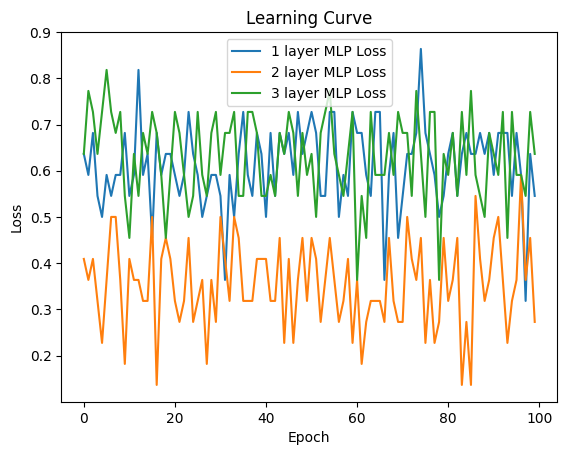

In [43]:
## define the network
input_size = 30
model_1 = MLP_1(input_size)
model_5 = MLP_5(input_size)
model_3 = MLP_3(input_size)
num_epochs = 100
## train it
loss_df_1 = train_model(train_dl, model_1, num_epochs)
loss_df_5 = train_model(train_dl, model_5, num_epochs)
loss_df_3 = train_model(train_dl, model_3, num_epochs)
## eval
acc_1 = evaluate_model(test_dl, model_1)
acc_5 = evaluate_model(test_dl, model_5)
acc_3 = evaluate_model(test_dl, model_3)
print("Accuracy for 1 layer: %.3f" % acc_1)
print("Accuracy for 3 layers: %.3f" % acc_3)
print("Accuracy for 5 layers: %.3f" % acc_5)

## plot epochs vs loss
plot_learning_curve(
    loss_df_1,
    loss_df_3,
    loss_df_5,
    model_names=["1 layer MLP", "3 layer MLP", "5 layer MLP"],
)

**Part 2: Please use either ChatGPT (available through OpenAI.com) or GPT4 (available as the New Bing).  Carry out a dialogue on a topic of interest to you (technical or otherwise).  Describe your impressions (2 paragraphs are sufficient).**